## 다이나믹 프로그래밍

다이나믹 프로그래밍은 model-based 접근법으로, 환경의 전이 확률과 보상을 알고 있을 때 사용됩니다. 이번 코드에서는 DP 기법의 가치 이터레이션 (Value Iteration), 정책 이터레이션 (Policy Iteration)을 활용해 최적 정책을 찾습니다.

다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
GridWorld는 격자 기반 환경으로, 에이전트가 상, 하, 좌, 우로 이동하며 목표 지점에 도달해야 합니다.

```py
start_point = (0,0) # 시작점
end_point = (4,4) # 목표 지점
gridworld_size = (5,5) # 5x5 크기의 격자
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [15]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [16]:
class MyGridWorld(GridWorldEnvironment):
    def render(self):
        super().render()

        print(f"Agent's current location: {self.traces[-1]}")
        print(f"Total number of moves: {len(self.traces)}")

        print("Reward Table")
        for row in self.reward:
            print(row)

env = MyGridWorld(start_point=(0, 0), end_point=(4, 4), grid_world_size=(5, 5))

# 예시 이동 경로 설정
env.traces = [(0, 0), (0,1), (1, 1), (2,1), (2,2), (2, 3), (3, 3), (3, 4), (4, 4)]

# 그리드 월드 상태 출력
env.render()

S X . . . 
. X . . . 
. X X X . 
. . . X X 
. . . . A 

Agent's current location: (4, 4)
Total number of moves: 9
Reward Table
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1]


# 01. 정책 이터레이션
정책 이터레이션은 정책 평가와 정책 개선을 번갈아 수행하며 최적 정책을 찾아가는 방법입니다.

- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

1. get_policy : 현재 상태에서의 정책 반환
2. get_value	: 현재 상태의 가치 반환
3. get_action : 현재 정책에 따라 행동 선택
4. policy_evaluation : 정책을 기준으로 가치 함수 업데이트
5. policy_improvement : 가치 함수를 이용해 최적 정책을 찾음

In [17]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
        return self.policy_table[state[0]][state[1]]

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

    def get_action(self,state):
        policy = self.get_policy(state)
        policy = np.array(policy)
        return np.random.choice(self.num_action, 1, p=policy)[0]

    def policy_evaluation(self):
        next_value_table = [[0.00] * self.env.width
                            for _ in range(self.env.height)]

        for state in self.env.total_states:
            value = 0.0
            if state == self.env.end_point:
                next_value_table[state[0]][state[1]] = value
                continue
            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                if len(self.get_policy(state)) > 0:
                    value += (self.get_policy(state)[action_idx] *
                          (reward + self.gamma * next_value)) # 정책이 비어 있지 않을 때만 접근
                next_value_table[state[0]][state[1]] = value

        self.value_table = next_value_table

    def policy_improvement(self):
        next_policy_table = self.policy_table

        for state in self.env.total_states:
            if state == self.env.end_point:
                continue

            value_list = []
            result = [0.0, 0.0, 0.0, 0.0]

            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                value_list.append(value)

            max_idx_list = np.argwhere(value_list == np.amax(value_list))
            max_idx_list = max_idx_list.flatten().tolist()
            prob = 1 / len(max_idx_list)

            for idx in max_idx_list:
                result[idx] = prob

            next_policy_table[state[0]][state[1]] = result

        self.policy_table = next_policy_table

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [18]:
policy_iteration = PolicyIteration(env)

value_deltas = []

# 정책 이터레이션 실행
max_iterations = 1000
threshold = 1e-4 # 수렴 판단 기준

for i in range(max_iterations):
    old_value_table = np.array(policy_iteration.value_table)

    # 1. 정책 평가
    policy_iteration.policy_evaluation()

    # 2. 정책 발전
    policy_iteration.policy_improvement()

    new_value_table = np.array(policy_iteration.value_table)
    delta = np.sum(np.abs(old_value_table - new_value_table))
    value_deltas.append(delta)
    if delta < threshold:
        print(f"Value table has converged")
        break

else:
    print("Reach the maximum number of iterations")

print("Final Value Table:")
for row in policy_iteration.value_table:
    print(row)

print("Final Policy Table:")
for row in policy_iteration.policy_table:
    print(row)

Value table has converged
Final Value Table:
[0.47829690000000014, 0.5314410000000002, 0.5904900000000002, 0.6561000000000001, 0.7290000000000001]
[0.5314410000000002, 0.5904900000000002, 0.6561000000000001, 0.7290000000000001, 0.81]
[0.5904900000000002, 0.6561000000000001, 0.7290000000000001, 0.81, 0.9]
[0.6561000000000001, 0.7290000000000001, 0.81, 0.9, 1.0]
[0.7290000000000001, 0.81, 0.9, 1.0, 0.0]
Final Policy Table:
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], []]


## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

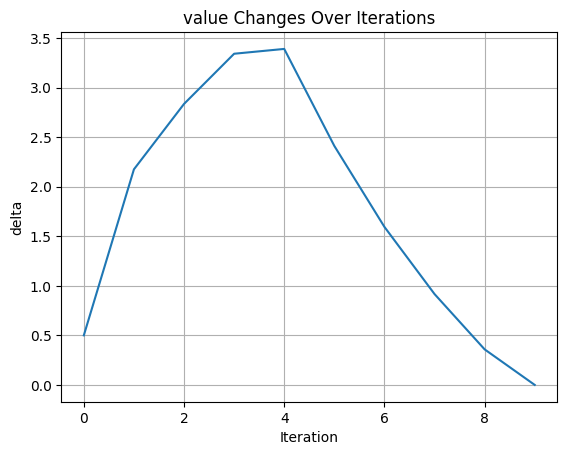

In [19]:
import matplotlib.pyplot as plt

plt.plot(value_deltas)
plt.title("value Changes Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.grid(True)
plt.show()

# 02. 가치 이터레이션
가치 이터레이션은 정책 없이 직접 가치 함수를 최적화하는 방법입니다.
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.
1. value_iteration : 벨만 최적 방정식을 이용해 가치 함수를 반복적으로 업데이트
2. get_value : 현재 상태의 가치를 반환
3. get_action : 현재 가치 함수 기준으로 최적 행동 선택

In [20]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율

    def value_iteration(self):
        next_value_table = [[0.00] * self.env.width
                            for _ in range(self.env.height)]

        for state in self.env.total_states:
            if state == self.env.end_point:
                next_value_table[state[0]][state[1]] = 0.0
                continue

            # 벨만 최적 방정식
            value_list = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value_list.append((reward + self.gamma * next_value))

            # 최댓값을 다음 가치함수로 대입
            next_value_table[state[0]][state[1]] = max(value_list)

        self.value_table = next_value_table

    def get_action(self, state):
        if state == self.env.end_point:
            return []

        # 모든 행동에 대해 큐함수(reward + (gamma * 다음 상태의 가치함수)) 계
        value_list = []
        for action_idx in range(self.num_actions):
            next_state = self.env.state_after_action(state, action_idx)
            reward = self.env.get_reward(state, action_idx)
            next_value = self.get_value(next_state)
            value = (reward + self.gamma * next_value)
            value_list.append(value)

        # 최대 큐함수를 가진 행동 반환 (여러 개일수도 있음)
        max_idx_list = np.argwhere(value_list == np.amax(value_list))
        action_list = max_idx_list.flatten().tolist()
        return action_list

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [21]:
value_iteration = ValueIteration(env)

value_deltas = []

max_iterations = 1000 # 최대 반복 횟수
threshold = 1e-4 # 수렴 판단 기준

for i in range(max_iterations):
    old_value_table = np.array(value_iteration.value_table)

    value_iteration.value_iteration()

    new_value_table = np.array(value_iteration.value_table)
    delta = np.sum(np.abs(old_value_table - new_value_table))
    value_deltas.append(delta)
    if delta < threshold:
        print(f"Value table has converged")
        break

else:
    print("Reach the maximum number of iterations")

# 최종 정책 및 가치 테이블 출력
print("Fianl Value Table:")
for row in value_iteration.value_table:
    print(row)

print("Final Policy Table:")
for state in env.total_states:
    print(f"Best Action of state{state}: {value_iteration.get_action(state)}")

Value table has converged
Fianl Value Table:
[0.47829690000000014, 0.5314410000000002, 0.5904900000000002, 0.6561000000000001, 0.7290000000000001]
[0.5314410000000002, 0.5904900000000002, 0.6561000000000001, 0.7290000000000001, 0.81]
[0.5904900000000002, 0.6561000000000001, 0.7290000000000001, 0.81, 0.9]
[0.6561000000000001, 0.7290000000000001, 0.81, 0.9, 1.0]
[0.7290000000000001, 0.81, 0.9, 1.0, 0.0]
Final Policy Table:
Best Action of state(0, 0): [1, 3]
Best Action of state(0, 1): [1, 3]
Best Action of state(0, 2): [1, 3]
Best Action of state(0, 3): [1, 3]
Best Action of state(0, 4): [1]
Best Action of state(1, 0): [1, 3]
Best Action of state(1, 1): [1, 3]
Best Action of state(1, 2): [1, 3]
Best Action of state(1, 3): [1, 3]
Best Action of state(1, 4): [1]
Best Action of state(2, 0): [1, 3]
Best Action of state(2, 1): [1, 3]
Best Action of state(2, 2): [1, 3]
Best Action of state(2, 3): [1, 3]
Best Action of state(2, 4): [1]
Best Action of state(3, 0): [1, 3]
Best Action of state(3, 

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

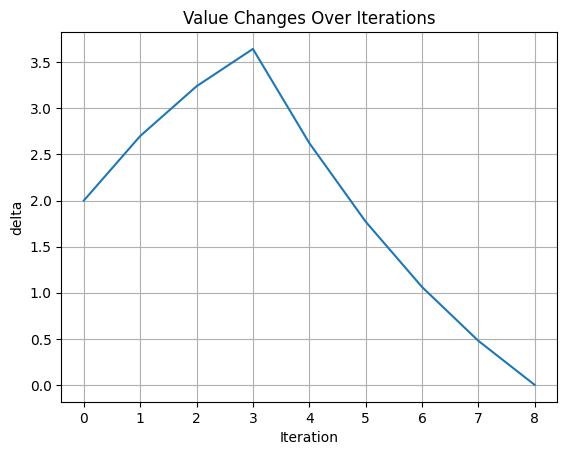

In [22]:
import matplotlib.pyplot as plt

plt.plot(value_deltas)
plt.title("Value Changes Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.grid(True)
plt.show()